In [1]:
from sklearn.base import BaseEstimator
from sklearn.base import ClassifierMixin
from sklearn.preprocessing import LabelEncoder
from sklearn.base import clone
from sklearn.pipeline import _name_estimators
import numpy as np
import operator

In [2]:
class MajorityVoteClassifier(BaseEstimator, ClassifierMixin): #継承によりset_paramsやget_paramsなどのメソッドを利用可
    def __init__(self, classifiers, vote = "classlabel", weights = None):
        self.classifiers = classifiers #array-like
        self.named_classifiers = {key: value for key, value in _name_estimators(classifiers)}
        self.vote = vote #str, ("classlabel", "probability")
        self.weights = weights
    def fit(self, X, y):
        if self.vote not in ("classlabel", "probability"):
            raise ValueError("Argument of vote is incorrect")
        if self.weights and len(self.weights) != len(self.classifiers):
            raise ValueError("Number of classifier and weights must be equal")
            
        self.labelenc_ = LabelEncoder()
        self.labelenc_.fit(y)
        self.classes_ = self.labelenc_.classes_
        self.classifiers_ = []
        
        for clf in self.classifiers:
            fitted_clf = clone(clf).fit(X, self.labelenc_.transform(y))
            self.classifiers_.append(fitted_clf)
        return self
    
    def predict(self, X):
        if self.vote == "probability":
            maj_vote = np.argmax(self.predict_proba(X), axis = 1)
        else: #"classlabel"
            #clf.predictの集計
            predictions = np.asarray([clf.predict(X) for clf in self.classifiers_]).T
            maj_vote = np.apply_along_axis(
            lambda x: np.argmax(np.bincount(x, weights = self.weights)), 
            axis = 1, arr = predictions) #各predictに重みをかけ合わせ、最頻値のインデックスを取得
            maj_vote = self.labelenc_.inverse_transform(maj_vote)
        return maj_vote
    
    def predict_proba(self, X):
        probas = np.asarray([clf.predict_proba(X) for clf in self.classifiers_])
        avg_proba = np.average(probas, axis = 0, weights = self.weights)
        return avg_proba
    
    def get_params(self, deep = True): #GridSearchの実行時にパラメータを取得
        if not deep:
            return super().get_params(deep = False)
        else:
            out = self.named_classifiers.copy()
            for name, step in self.named_classifiers.items():
                for value, key in step.get_params(deep = True).items():
                    out[f"{name}__{key}"] = value
            return out

In [3]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

iris = datasets.load_iris()
X, y = iris.data[50:, [1, 2]], iris.target[50:]
le = LabelEncoder()
y = le.fit_transform(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.5, random_state = 1, stratify = y)

In [4]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline

clf1 = LogisticRegression(penalty = "l2", C = 0.001, solver = "lbfgs", random_state = 1)
clf2 = DecisionTreeClassifier(max_depth = 1, criterion = "entropy", random_state = 0)
clf3 = KNeighborsClassifier(n_neighbors = 1, p = 2, metric = "minkowski")

pipe1 = Pipeline([["sc", StandardScaler()],["clf", clf1]])
pipe3 = Pipeline([["sc", StandardScaler()],["clf", clf3]])
clf_labels = ["Logistic regression", "Decision tree", "KNN"]
print("10-fold cross validation:\n")
for clf, label in zip([pipe1, clf2, pipe3], clf_labels):
    scores = cross_val_score(estimator = clf, X = X_train, y = y_train, cv = 10, scoring = "roc_auc")
    print(f"ROC AUC: {scores.mean():.2f} +/- {scores.std():.2f} [{label}]")

10-fold cross validation:

ROC AUC: 0.92 +/- 0.15 [Logistic regression]
ROC AUC: 0.87 +/- 0.18 [Decision tree]
ROC AUC: 0.85 +/- 0.13 [KNN]


In [5]:
mv_clf = MajorityVoteClassifier(classifiers = [pipe1, clf2, pipe3])
clf_labels += ["Majority voting"]
all_clf = [pipe1, clf2, pipe3, mv_clf]
for clf, label in zip(all_clf, clf_labels):
    scores = cross_val_score(estimator = clf, X = X_train, y = y_train, cv = 10, scoring = "roc_auc")
    print(f"ROC AUC: {scores.mean():.2f} +/- {scores.std():.2f} [{label}]")

ROC AUC: 0.92 +/- 0.15 [Logistic regression]
ROC AUC: 0.87 +/- 0.18 [Decision tree]
ROC AUC: 0.85 +/- 0.13 [KNN]
ROC AUC: 0.98 +/- 0.05 [Majority voting]


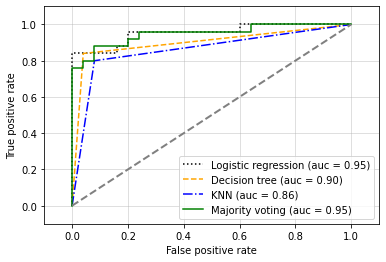

In [6]:
#ROC曲線
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

colors = ["black", "orange", "blue", "green"]
linestyles = [":", "--", "-.", "-"]

for clf, label, clr, ls in zip(all_clf, clf_labels, colors, linestyles):
    y_pred = clf.fit(X_train, y_train).predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_true = y_test, y_score = y_pred)
    roc_auc = auc(x = fpr, y = tpr)
    plt.plot(fpr, tpr, color = clr, linestyle = ls, label = f"{label} (auc = {roc_auc:.2f})")

plt.legend(loc = "lower right")
plt.plot([0, 1], [0, 1], linestyle = "--", color = "gray", linewidth = 2)
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.grid(alpha = 0.5)
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.show()

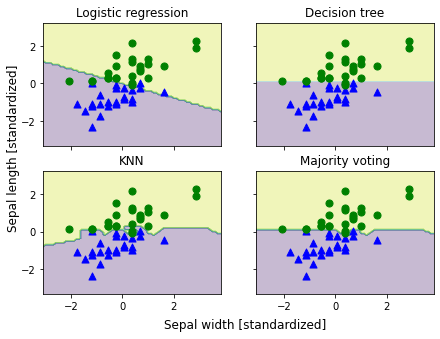

In [7]:
#プロット
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
from itertools import product #入れ子のジェネレータ式と同じ

x_min = X_train_std[:, 0].min() -1
x_max = X_train_std[:, 0].max() +1
y_min = X_train_std[:, 1].min() -1
y_max = X_train_std[:, 1].max() +1

xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))

f, axarr = plt.subplots(nrows = 2, ncols = 2, sharex = "col", sharey = "row", figsize = (7,5))

for idx, clf, tt in zip(product([0, 1], [0, 1]), all_clf, clf_labels):
    clf.fit(X_train_std, y_train)
    z = clf.predict(np.c_[xx.ravel(), yy.ravel()]) #np.c_ = 列ベクトル化して水平結合
    z = z.reshape(xx.shape)
    axarr[idx[0], idx[1]].contourf(xx, yy, z, alpha = 0.3)
    axarr[idx[0], idx[1]].scatter(X_train_std[y_train == 0, 0],
                                  X_train_std[y_train == 0, 1],
                                  c = "blue", marker = "^", s = 50)
    axarr[idx[0], idx[1]].scatter(X_train_std[y_train == 1, 0],
                                  X_train_std[y_train == 1, 1],
                                  c = "green", marker = "o", s = 50)
    axarr[idx[0], idx[1]].set_title(tt)

plt.text(-3.5, -5., s = "Sepal width [standardized]",
         ha = "center", va = "center", fontsize = 12)
plt.text(-12.5, 4.5, s = "Sepal length [standardized]",
         ha = "center", va = "center", fontsize = 12, rotation = 90)

plt.show()

In [8]:
mv_clf.get_params()

{'pipeline-1': Pipeline(steps=[('sc', StandardScaler()),
                 ['clf', LogisticRegression(C=0.001, random_state=1)]]),
 'decisiontreeclassifier': DecisionTreeClassifier(criterion='entropy', max_depth=1, random_state=0),
 'pipeline-2': Pipeline(steps=[('sc', StandardScaler()),
                 ['clf', KNeighborsClassifier(n_neighbors=1)]]),
 'pipeline-1__None': 'clf__n_jobs',
 "pipeline-1__[('sc', StandardScaler()), ['clf', LogisticRegression(C=0.001, random_state=1)]]": 'steps',
 'pipeline-1__False': 'clf__warm_start',
 'pipeline-1__StandardScaler()': 'sc',
 'pipeline-1__LogisticRegression(C=0.001, random_state=1)': 'clf',
 'pipeline-1__True': 'clf__fit_intercept',
 'pipeline-1__0.001': 'clf__C',
 'pipeline-1__1': 'clf__random_state',
 'pipeline-1__100': 'clf__max_iter',
 'pipeline-1__auto': 'clf__multi_class',
 'pipeline-1__l2': 'clf__penalty',
 'pipeline-1__lbfgs': 'clf__solver',
 'pipeline-1__0.0001': 'clf__tol',
 'pipeline-1__0': 'clf__verbose',
 'decisiontreeclassifier_

In [9]:
from sklearn.model_selection import GridSearchCV

params = {"decisiontreeclassifier__max_depth": [1, 2],
         "pipeline-1__clf__C": [0.001, 0.1, 100.0]}
grid = GridSearchCV(estimator = mv_clf, param_grid = params, cv = 10, scoring = "roc_auc")
grid.fit(X_train, y_train)

for r, _ in enumerate(grid.cv_results_["mean_test_score"]):
    mean_score = grid.cv_results_["mean_test_score"][r]
    std_dev = grid.cv_results_["std_test_score"][r]
    params = grid.cv_results_["params"][r]
    print(f"{mean_score:.3f} +/- {std_dev:.3f} {params}")

0.983 +/- 0.050 {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 0.001}
0.983 +/- 0.050 {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 0.1}
0.967 +/- 0.100 {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 100.0}
0.983 +/- 0.050 {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 0.001}
0.983 +/- 0.050 {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 0.1}
0.967 +/- 0.100 {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 100.0}


In [10]:
print(f"Best parameters: {grid.best_params_}")
print(f"ROC AUC : {grid.best_score_:.3f}")

Best parameters: {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 0.001}
ROC AUC : 0.983


In [11]:
#バギング
import pandas as pd

df_wine = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data", header = None)
df_wine.columns = ["Class label", "Alcohol", "Malic acid", "Ash", "Alcalinity of ash", "Magnesium", "Total phenols", 
                   "Flavanoids", "Nonflavanoid phenols", "Proanthocyanins", "Color intensity", "Hue", 
                   "OD280/OD315 of diluted wines", "Proline"]
df_wine = df_wine[df_wine["Class label"] != 1]

y = df_wine["Class label"].values
X = df_wine[["Alcohol", "OD280/OD315 of diluted wines"]].values

In [12]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

le = LabelEncoder()
y = le.fit_transform(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y, random_state = 1)

In [13]:
from sklearn.ensemble import BaggingClassifier

tree = DecisionTreeClassifier(criterion = "entropy", max_depth = None, random_state = 1)
bag = BaggingClassifier(estimator = tree,
                        n_estimators = 500, #決定木の数
                        max_samples = 1.0,
                        max_features = 1.0,
                        bootstrap = True,
                        bootstrap_features = False,
                        n_jobs = 1,
                        random_state = 1)

In [14]:
#1本の決定木の精度
from sklearn.metrics import accuracy_score

tree.fit(X_train, y_train)
y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)
tree_train = accuracy_score(y_train, y_train_pred)
tree_test = accuracy_score(y_test, y_test_pred)
print(f"Decision tree train/test accuracies: {tree_train:.3f}/{tree_test:.3f}")

Decision tree train/test accuracies: 1.000/0.833


In [15]:
#バギングした決定木の精度
bag.fit(X_train, y_train)
y_train_pred = bag.predict(X_train)
y_test_pred = bag.predict(X_test)
bag_train = accuracy_score(y_train, y_train_pred)
bag_test = accuracy_score(y_test, y_test_pred)
print(f"Bagging train/test accuracies: {bag_train:.3f}/{bag_test:.3f}")

Bagging train/test accuracies: 1.000/0.917


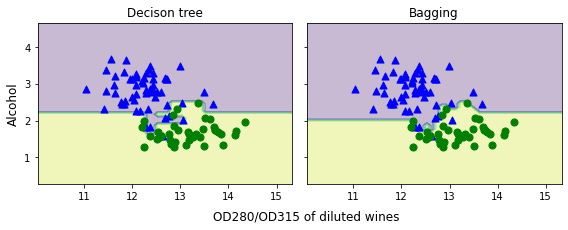

In [16]:
x_min = X_train[:, 0].min() - 1
x_max = X_train[:, 0].max() + 1
y_min = X_train[:, 1].min() - 1
y_max = X_train[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))
f, axarr = plt.subplots(nrows = 1, ncols = 2, sharex = "col", sharey = "row", figsize = (8, 3))

for idx, clf, tt in zip([0, 1], [tree, bag], ["Decison tree", "Bagging"]):
    clf.fit(X_train, y_train)
    z = clf.predict(np.c_[xx.ravel(), yy.ravel()]) #np.c_ = 列ベクトル化して水平結合
    z = z.reshape(xx.shape)
    axarr[idx].contourf(xx, yy, z, alpha = 0.3)
    axarr[idx].scatter(X_train[y_train == 0, 0],
                                  X_train[y_train == 0, 1],
                                  c = "blue", marker = "^", s = 50)
    axarr[idx].scatter(X_train[y_train == 1, 0],
                                  X_train[y_train == 1, 1],
                                  c = "green", marker = "o", s = 50)
    axarr[idx].set_title(tt)

axarr[0].set_ylabel("Alcohol", fontsize = 12)
plt.tight_layout()
plt.text(0, -0.2, s = "OD280/OD315 of diluted wines", ha = "center", va = "center", fontsize = 12, transform = axarr[1].transAxes)
plt.show()

In [17]:
#AdaBoostの例
y = np.array([1, 1, 1, -1, -1, -1, 1, 1, 1, -1])
yhat = np.array([1, 1, 1, -1, -1, -1, -1, -1, -1, -1])
correct = (y == yhat)
weights = np.full(10, 0.1)
epsilon = np.mean(~correct) #~はTrueとFalseの反転
alpha_j = 0.5 * np.log((1 - epsilon) / epsilon) #α= log((1-ε)/ε)

update_if_correct = 0.1 * np.exp(-alpha_j * 1 * 1) #w:=w*exp(-α*y*y^)
update_if_wrong = 0.1 * np.exp(-alpha_j * 1 * -1) #予測値と同じなら重みを減らし、異なれば重みを増やす

weights = np.where(correct == 1, update_if_correct, update_if_wrong)
normalized_weights = weights / np.sum(weights)
print(normalized_weights)

[0.07142857 0.07142857 0.07142857 0.07142857 0.07142857 0.07142857
 0.16666667 0.16666667 0.16666667 0.07142857]


In [18]:
from sklearn.ensemble import AdaBoostClassifier

tree = DecisionTreeClassifier(criterion = "entropy", max_depth = 1, random_state = 1)
ada = AdaBoostClassifier(estimator = tree, n_estimators = 500, learning_rate = 0.1, random_state = 1)
tree.fit(X_train, y_train)
y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)
tree_train = accuracy_score(y_train, y_train_pred)
tree_test = accuracy_score(y_test, y_test_pred)

print(f"Decison tree train/test accuracies: {tree_train:.3f}/{tree_test:.3f}")

Decison tree train/test accuracies: 0.916/0.875


In [19]:
ada.fit(X_train, y_train)
y_train_pred = ada.predict(X_train)
y_test_pred = ada.predict(X_test)
ada_train = accuracy_score(y_train, y_train_pred)
ada_test = accuracy_score(y_test, y_test_pred)

print(f"AdaBoost train/test accuracies: {ada_train:.3f}/{ada_test:.3f}")

AdaBoost train/test accuracies: 1.000/0.917


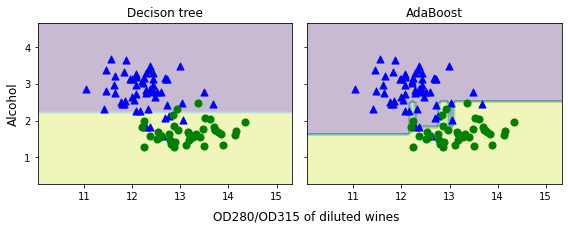

In [20]:
x_min = X_train[:, 0].min() - 1
x_max = X_train[:, 0].max() + 1
y_min = X_train[:, 1].min() - 1
y_max = X_train[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))
f, axarr = plt.subplots(nrows = 1, ncols = 2, sharex = "col", sharey = "row", figsize = (8, 3))

for idx, clf, tt in zip([0, 1], [tree, ada], ["Decison tree", "AdaBoost"]):
    clf.fit(X_train, y_train)
    z = clf.predict(np.c_[xx.ravel(), yy.ravel()]) #np.c_ = 列ベクトル化して水平結合
    z = z.reshape(xx.shape)
    axarr[idx].contourf(xx, yy, z, alpha = 0.3)
    axarr[idx].scatter(X_train[y_train == 0, 0],
                                  X_train[y_train == 0, 1],
                                  c = "blue", marker = "^", s = 50)
    axarr[idx].scatter(X_train[y_train == 1, 0],
                                  X_train[y_train == 1, 1],
                                  c = "green", marker = "o", s = 50)
    axarr[idx].set_title(tt)

axarr[0].set_ylabel("Alcohol", fontsize = 12)
plt.tight_layout()
plt.text(0, -0.2, s = "OD280/OD315 of diluted wines", ha = "center", va = "center", fontsize = 12, transform = axarr[1].transAxes)
plt.show()

In [27]:
#勾配ブースティング
import xgboost as xgb

model = xgb.XGBClassifier(n_estimators = 1000, learning_rate = 0.01, max_depth = 4, random_state = 1)
gbm = model.fit(X_train, y_train)
y_train_pred = gbm.predict(X_train)
y_test_pred = gbm.predict(X_test)
gbm_train = accuracy_score(y_train, y_train_pred)
gbm_test = accuracy_score(y_test, y_test_pred)
print(f"XGboost train/test accuracies: {gbm_train:.3f}/{gbm_test:.3f}")

XGboost train/test accuracies: 0.968/0.917
